In [1]:
import pandas as pd
import nltk
import re
import numpy as np
import time

# Imports para NLP
#from nltk import word_tokenize
from bs4 import BeautifulSoup
from nltk import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

start_time = time.time()

In [2]:
df = pd.read_csv('IMDB Dataset.csv')

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


#### Remover review duplicadas

In [5]:
df = df[~df.review.duplicated()]

#### Remover colunas null

In [6]:
df=df[~df.review.isnull()]

#### Limpeza

Método para limpeza de texto aplicando:
    - replace para um caractere específico
    - limpeza de linguagem html usando BeautifulSoup
    - regexp_tokenize para transformar textos em tokens, e coletar apenas palavras através do regex [\w']+. Ignorando acentos.
    - .lower() para deixar as palavras minusculas
    - stopwords para remover palavras que não agregam informações
    - stemming para extrair o radical das palavras

In [7]:
#nltk.download('stopwords')
ps = PorterStemmer()
eng_stpw = set(stopwords.words('english'))

def padronizardados(text):
    t = text.replace('\'','')
    soup = BeautifulSoup(t, "html.parser")
    text = regexp_tokenize(soup.get_text().lower(),"[\w']+")
    temp = []
    for t in text:
        if t not in eng_stpw:
            temp.append(t)
    new_text = (' '.join(temp))
    
    return new_text

##### Texto antes do método

In [8]:
df.review[30]

'Taut and organically gripping, Edward Dmytryk\'s Crossfire is a distinctive suspense thriller, an unlikely "message" movie using the look and devices of the noir cycle.<br /><br />Bivouacked in Washington, DC, a company of soldiers cope with their restlessness by hanging out in bars. Three of them end up at a stranger\'s apartment where Robert Ryan, drunk and belligerent, beats their host (Sam Levene) to death because he happens to be Jewish. Police detective Robert Young investigates with the help of Robert Mitchum, who\'s assigned to Ryan\'s outfit. Suspicion falls on the second of the three (George Cooper), who has vanished. Ryan slays the third buddy (Steve Brodie) to insure his silence before Young closes in.<br /><br />Abetted by a superior script by John Paxton, Dmytryk draws precise performances from his three starring Bobs. Ryan, naturally, does his prototypical Angry White Male (and to the hilt), while Mitchum underplays with his characteristic alert nonchalance (his role, h

##### Aplicando método de limpeza aos textos

In [9]:
df.review = df.review.apply(padronizardados)

##### Texto depois do método

In [10]:
df.review[30]

'taut organically gripping edward dmytryks crossfire distinctive suspense thriller unlikely message movie using look devices noir cycle bivouacked washington dc company soldiers cope restlessness hanging bars three end strangers apartment robert ryan drunk belligerent beats host sam levene death happens jewish police detective robert young investigates help robert mitchum whos assigned ryans outfit suspicion falls second three george cooper vanished ryan slays third buddy steve brodie insure silence young closes abetted superior script john paxton dmytryk draws precise performances three starring bobs ryan naturally prototypical angry white male hilt mitchum underplays characteristic alert nonchalance role however central young may never better gloria grahame gives first fully fledged rendition smart mouthed vulnerable tramp sad sack whos leeched life paul kelly haunts us small peripheral role makes memorable politically engaged dmytryk perhaps inevitably succumbs sermonizing pretty mu

#### Transformar sentiments em 0 e 1 (Label encoder)

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.sentiment= le.fit_transform(df.sentiment)

In [12]:
df = df.rename(columns={"sentiment" : "positive"})

##### Função plot

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

##### Split dados
    - Optei por separar os dados em treino, validação e teste

In [14]:
from sklearn.model_selection import train_test_split
  
X_train, X_test, y_train, y_test  = train_test_split(df.review, df.positive, test_size=0.2, random_state=1)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [38]:
from keras.preprocessing.text import Tokenizer

#Número máximo de palavras do X_train é 100619
tokenizer = Tokenizer(num_words=10000) #10000 #20000 #30000 #OVERFITTING
#tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

x_train = tokenizer.texts_to_sequences(X_train)
x_test = tokenizer.texts_to_sequences(X_test)
x_val = tokenizer.texts_to_sequences(X_val)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

tokenizer.word_index

for word in ['one', 'review','mention','watch','1','oz','episod','youll','hook','right','exactli','happen']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

* pad_sequence: One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use pad_sequence() which simply pads the sequence of words with zeros.

* maxlen = how long the sequences should be

In [39]:
from keras.preprocessing.sequence import pad_sequences

#maxlen = max(len(x) for x in x_train) # longest text in train set
maxlen = 100

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)
x_val = pad_sequences(x_val, padding='post', maxlen=maxlen)

print(x_train[0, :])

[  92    1 3325  110   76   57    4  210 3539 7444 3187 5748  398   92
  179  740  922  117  129   19 6454  639   73  595  131  157    6  232
  203  225  321    1 2371 1042   27   37  572 2958  175    3  151 4065
   43   31   63  407   80  677  144    1   84 3580   74 3391   76   20
   84  343    6 2746   18   49   63    1  116  677  144 2060  484    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [40]:
maxlen

100

* input_dim:tamanho do vocabulary
* output_dim: tamanho do vetor
* input_length: tamanho da entrada

In [41]:
from keras.models import Sequential
from keras import layers

embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(1, 1, activation='relu'))
#model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling1D(pool_size=2))
#model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          10062000  
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 1)            101       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 50, 1)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 10,062,152
Trainable params: 10,062,152
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(x_val, y_val),
                    batch_size=128)

In [43]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_val, y_val, verbose=False)
print("Val Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7755
Val Accuracy:  0.7568
Testing Accuracy:  0.7477


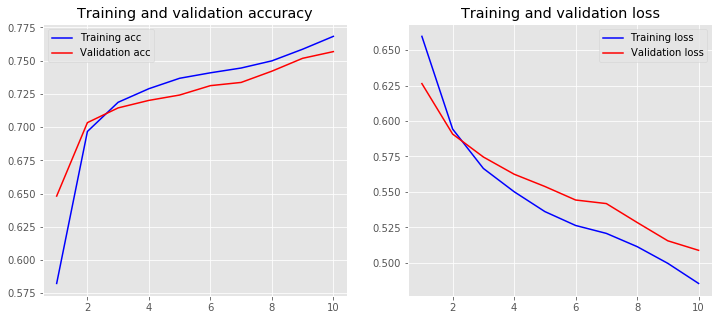

In [44]:
plot_history(history)

In [101]:
from keras.layers import Dense, Activation, Dropout, Flatten, Input
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.models import Model, Sequential 
from keras.layers.merge import concatenate
from numpy import array

def define_model(length, vocab_size):
# channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 100)(inputs1)
    conv1 = Conv1D(filters=1, kernel_size=1, activation='relu')(embedding1)
    #drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 100)(inputs2)
    conv2 = Conv1D(filters=1, kernel_size=1, activation='relu')(embedding2)
    #drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 100)(inputs3)
    conv3 = Conv1D(filters=1, kernel_size=1, activation='relu')(embedding3)
    #drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(conv3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    #dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize
    print(model.summary())

    return model

In [102]:
model = define_model(maxlen, vocab_size)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 100, 100)     10062000    input_22[0][0]                   
____________________________________________________________________________________________

In [103]:
history = model.fit([x_train,x_train,x_train], y_train,
                    epochs=5,validation_data=([x_val,x_val,x_val], y_val),
                    batch_size=1000)

Train on 39665 samples, validate on 4959 samples
Epoch 1/5
39665/39665 [==============================] - 21s 518us/step - loss: 0.6902 - acc: 0.5245 - val_loss: 0.6877 - val_acc: 0.5199
Epoch 2/5
39665/39665 [==============================] - 18s 451us/step - loss: 0.6572 - acc: 0.6162 - val_loss: 0.6410 - val_acc: 0.6388
Epoch 3/5
39665/39665 [==============================] - 17s 432us/step - loss: 0.5299 - acc: 0.7753 - val_loss: 0.4655 - val_acc: 0.7897
Epoch 4/5
39665/39665 [==============================] - 17s 422us/step - loss: 0.3705 - acc: 0.8445 - val_loss: 0.3778 - val_acc: 0.8308
Epoch 5/5
39665/39665 [==============================] - 17s 424us/step - loss: 0.2996 - acc: 0.8762 - val_loss: 0.3522 - val_acc: 0.8421


In [104]:
loss, accuracy = model.evaluate([x_train,x_train,x_train], y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate([x_val,x_val,x_val], y_val, verbose=False)
print("Val Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate([x_test,x_test,x_test], y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8940
Val Accuracy:  0.8421
Testing Accuracy:  0.8364


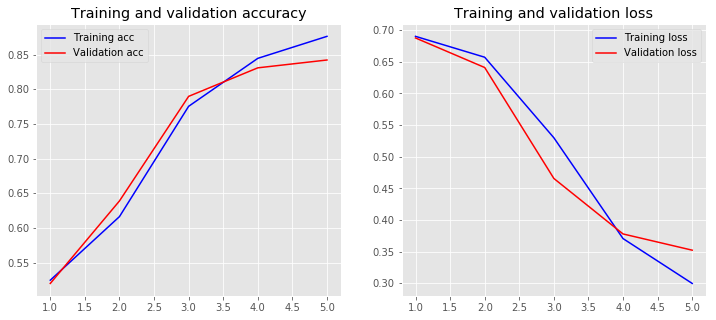

In [105]:
plot_history(history)